# tfutils: a Python API for Tracab XML files
> A soccer-language interface for reading and interacting with soccer data from Tracab XML files.

- toc:true
- badges: true
- comments: true
- author: Luca Cazzanti
- categories: [soccer analytics, python, tracab, instat, heatmap]
- image: images/TO_DO.png

# Summary
I wanted to be able to parse, access, and plot easily the soccer match data contained in Tracab TF05 XML files. I wanted to use the semantics of soccer to explore the data, as opposed to technical XML parsing jargon, so I wrote a little Python library called [tfutils](https://github.com/lucacazzanti/tfutils) for this purpose. In this blog I go over the structure of a tracab TF05 XML file and illustrate how to use the tfutils library to plot team and player heatmaps, which are the bulk of the information contained in the TF05 files. I use a TF05 XML file from the [Syria vs. Mauritania match](https://www.youtube.com/watch?v=nE8EGvTNRSo&feature=share&utm_source=EJGixIgBCJiu2KjB4oSJEQ) of 6 December 2021, group stage of the Arab Cup for the examples. 

At the moment [tfutils](https://github.com/lucacazzanti/tfutils) supports only TF05 files, but can easily be expanded to other Tracab XML files, and to Tracab ```.dat``` tracking data files. Soccer clubs with robust data engineering practices have automated ingestion pipelines that take XML Tracab feeds and put them in databases which power downstream visualizations and drill-down analyses. If your club does not have these processes in place, or you don't have access to these curated databases,  ```tfutils``` will get you started with your analyses with an easy direct interfaces to the XML feed. Installation instructions are [here](https://github.com/lucacazzanti/tfutils).

# Content and structure of a Tracab TF05 XML file
Tracab TF05 XML files contain summary match data, like team names, player names, match date, but the heatmaps make up bulk of the information. These heatmaps summarize  the pitch locations where teams and individual players have been present. This information can form part of pre- and post-match analysis reports, or general opponent research. The first few lines of a Tracab TF05 XML file look like this:

![TF05 snippet](./img/tf05_xml_screenshot.PNG)

Diferent types of heatmaps provide team-level and player-level information: 
## Combined team heatmaps
* __Overall:__ combined team heatmap, over the entire match duration
* __Defence:__ combined heatmap of the team defenders
* __Midfield:__ combined ehatmap of the team midfielders
* __Attack:__ combined heatmap of the team attackers.

Unfortunately, the Tracab TF05 feed does not tell us the players who are part of the defence, midfield, and attack heatmaps, so we are left with just an intuitive notion of which players contribute to which heatmap. On the positive side, we have access to team heatmaps separated by phases of the game (in/out of possession) and by period (first half, second helf):  

* __In possession or out of possession__. For each of these two phases, we have these combined team heatmaps: 
  * Overall
  * First half
  * Second half

## Individual player heatmaps
Similar to the combined team heatmaps, possession heatmaps are available for each player, in addition to the player's overall heatmap. First-half and second-half heatmaps are not available for individual players.
* __Overall:__ a player's overall heatmap for the entire match duration.
* __In possession or out of possession__. For each of these two phases, we have these player heatmaps:
  - Overall
  - First half
  - Second half
  
## Structure of a heatmap
A heatmap in a Tracab TF05 feed is represented as a long string of 240 character digits, each digit an integer between 0-9. These 240 digits are associated with 240 pitch locations, and the corresponding integers represent the time a team (or a player) spent in that location. The numbers 0-9 are normalized time values, where 0 means "no time" and 9 means "maximum time." Unfortunately, I do not know the normaalization applied to the time spent in each location, so I cannot say what "maximum time" means. For this reason, a safe approach to interpreting these numbers is to view them only in relation to the rest of the same heatmap, and not relative to other heatmaps. So for example, I cannot tell if a "9" from player X represents the same absolute length of time as a "9" for player Y, but I am sure that for player X a "9" means more time spent in a particular location than a "4". Here's what a heatmap tag looks like in the XML feed:
![tf05 heatmap tag](img/tf05_xml_heatmap_string.png)

The 240 character digits map to a 24x20 matrix overlaid on the pitch, with the top left corner corrsponding to the first digit, and the bottom right corner to the last. Here's a snapshot from Tracab's documentation, which however __is incorrect!__ The documentation states that heatmaps are made of 200 digits (20x10), but I found out the hard way that it's actullally 240. Nonetheless, the figure below gives you the general idea. Note that all heatmaps assume that the attacking direction is left-to-right, irrespective of the actual attacking direction during the match. In other words, all heatmaps have been standardized on a left-to-right attacking reference. 

![tracab heatmap_overlay](img/tracab_heatmap.png)

# Plotting the team-level heatmaps
Getting started with TF05 file, you'll want to read basic information about the match, get a list of players, and plot the two team's heatmaps. It's interesting that this XML feed does not include the final score. I guess a club that uses Tracab as data provider would have access to other Tracab feeds, which merged with this one, give a more complete picture of the match, including the final score. In any case, [I happen to know](https://instatsport.com) that the final score for this match was Syria 1 - Mauritania 2. 

In [1]:
from tfutils import TracabTf05Xml
source = TracabTf05Xml('../data/129650_TF05_PMS.xml')
source.parse()
source.summary()

Source file: ../data/129650_TF05_PMS.xml
Home team name and ID:Syria, 43838
Away team name and ID: Mauritania, 43870
Match date: 2021-12-06 18:00:00
Match ID: 129650
Match duration: 98.614 minutes


## Syria and Mauritania's overall heatmaps
Let's start simple: the overall heatmaps for the two teams. Immediately we can see that Syria, the home team, explored more of the length of the pitch, especially the central channel. Mauritania, instead, spent more time in its own half. So, chances are that Syria attacked more and had more ball possession that Mauritania, which likely was either content to apply a low block, or was pressured by Syria into a more defensive stance. These are preliminary hypotheses for sure but what I like about this approach is that you can immediately start formulating ideas about what happened during the match which can guide your subsequent analysis steps. Of course you should cross-check with other sources of information, including actually watching the match of course!

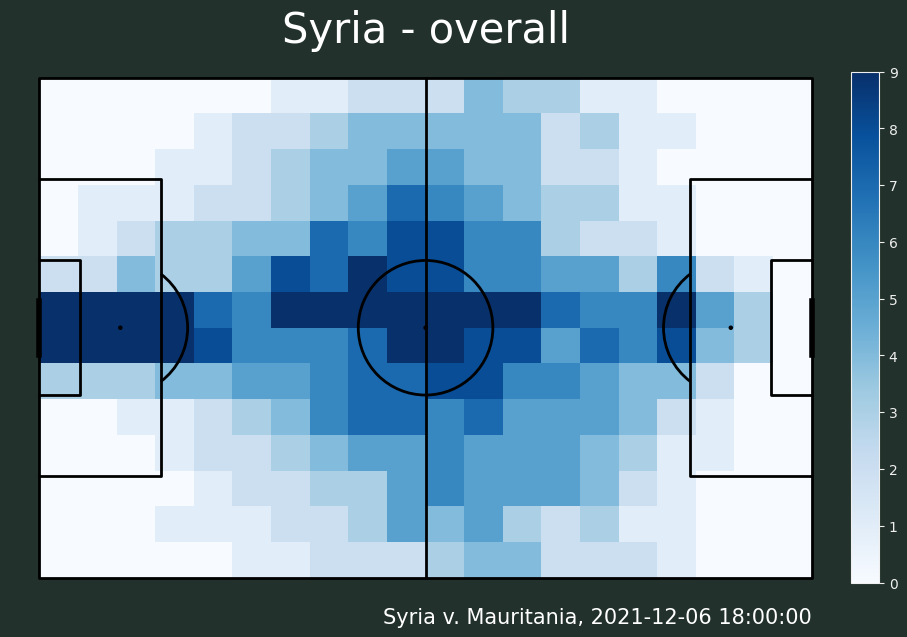

In [8]:
p = source.team_heatmap('home', add_cbar=True) # You can also call this method with the name of the team: source.team_heatmap('Syria')

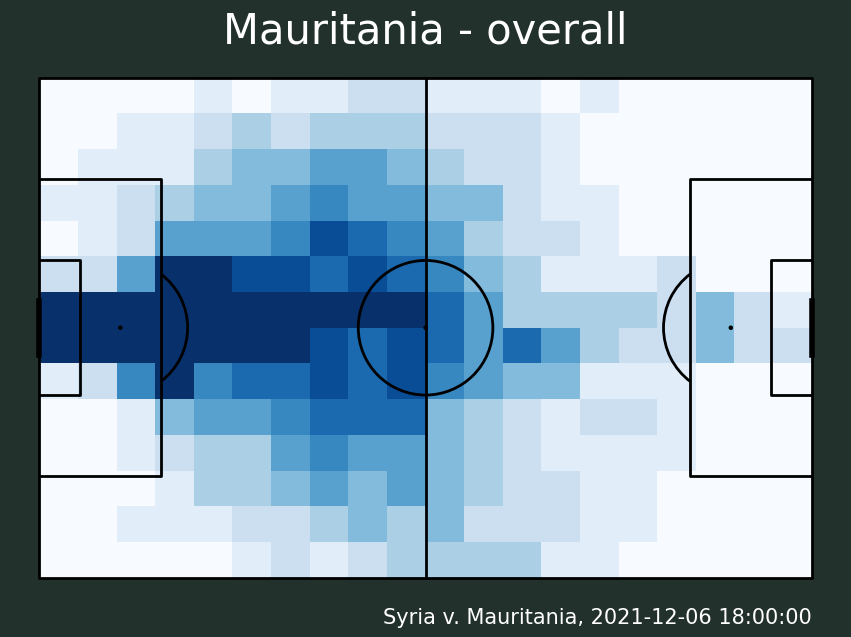

In [3]:
p = source.team_heatmap('away')

## Heatmaps for defense, midfield, and attack
It is not surprising that when breaking down the heatmaps of the two teams by unit, we see patterns consistent with the overall heatmaps above. Syria pushed into Mauritania's half more, mostly in the central channel, while Mauritania swelled more in its own half; in fact Mauritania's attackers seemed to have spent more time close to the midfield, while the midfielders were essentially playing defense. One thing stood out to me when comparing Syria's defense with Maritania's. In Syria's case, the defenders cover both the right and left sides in a symmetrical cone, following almost exactly the shape of the defensive funnel. In contrast, Mauritania's defenders covered the right (bottom) half od the funnel, while the midfielders covered the left (top). However, remember that we do not know how Tracab decides which players are defenders and which ones are midfielders, so it is possible that this is an artifact of the data rather than an actual tactical choice by Mauritania. This is where other sources of information, like watching the match or other data surces, can help get a deeper understanding, in addition to human experts of course.   

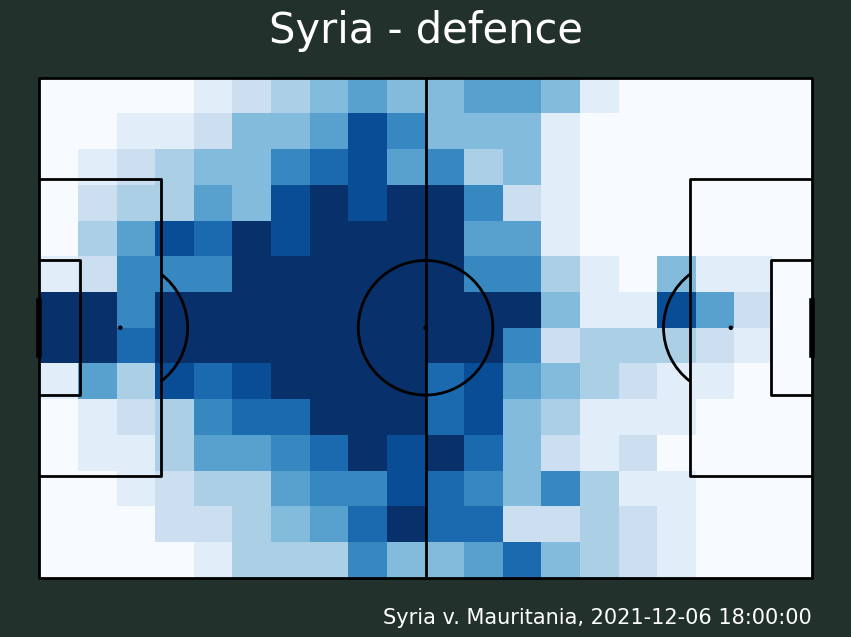

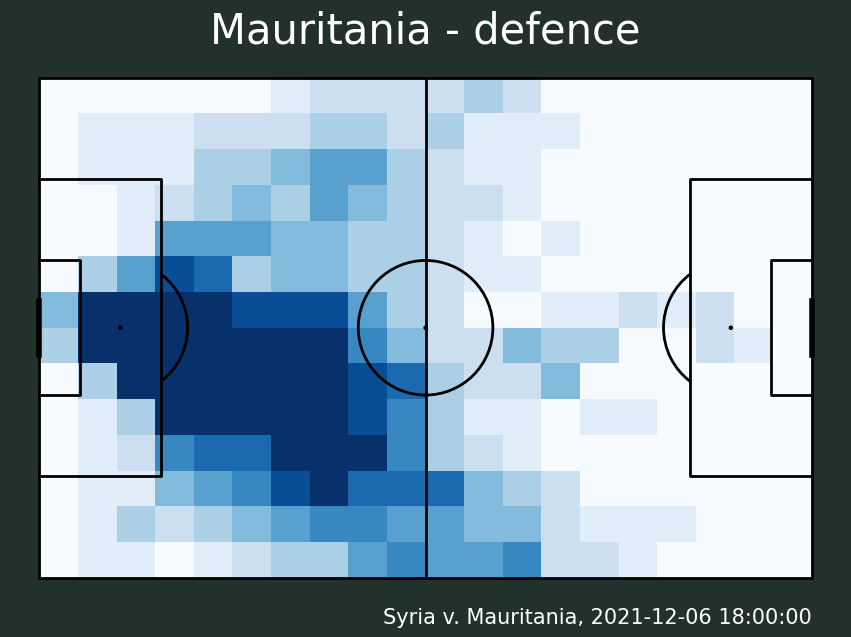

In [14]:
p = source.team_heatmap('Syria', hm_type='defence')
p = source.team_heatmap('Mauritania', hm_type='defence')

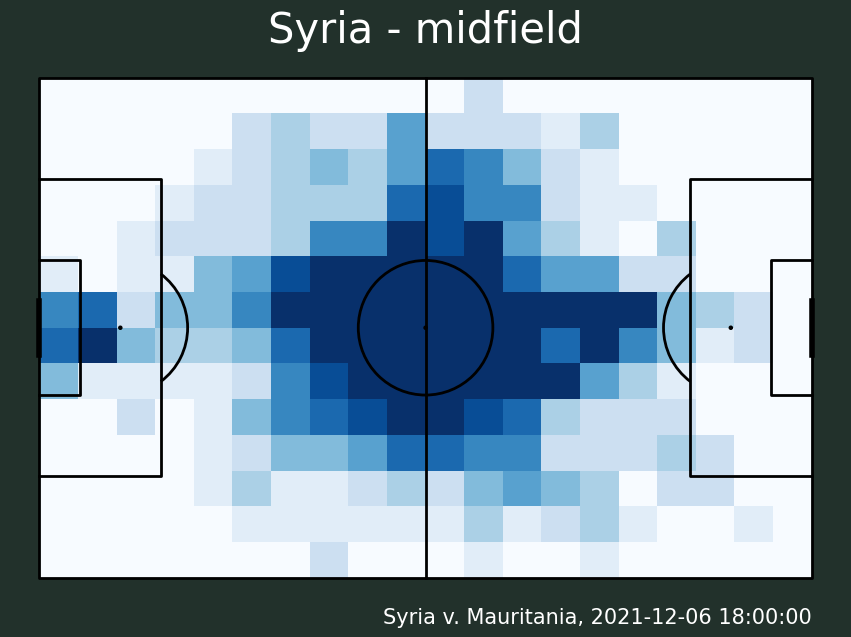

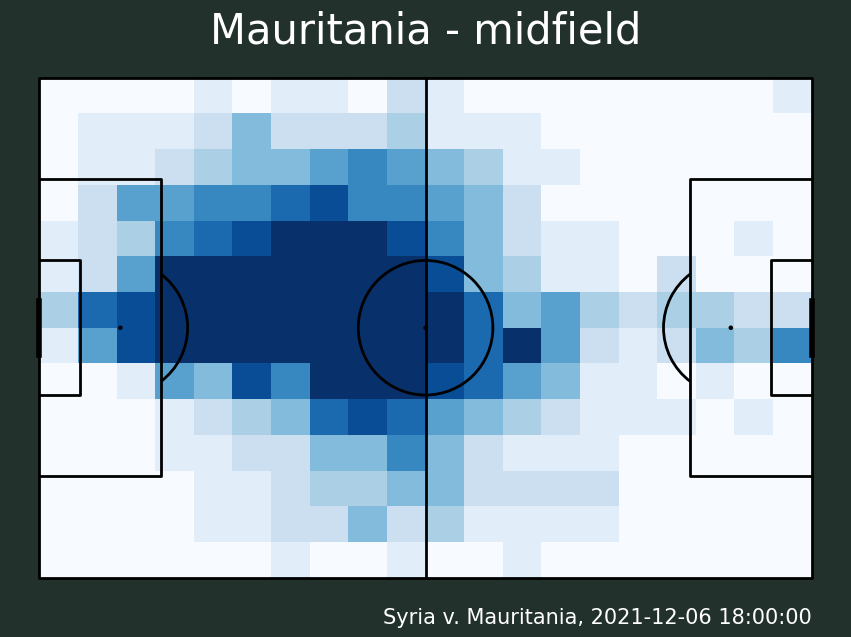

In [15]:
p = source.team_heatmap('Syria', hm_type='midfield')
p = source.team_heatmap('Mauritania', hm_type='midfield')

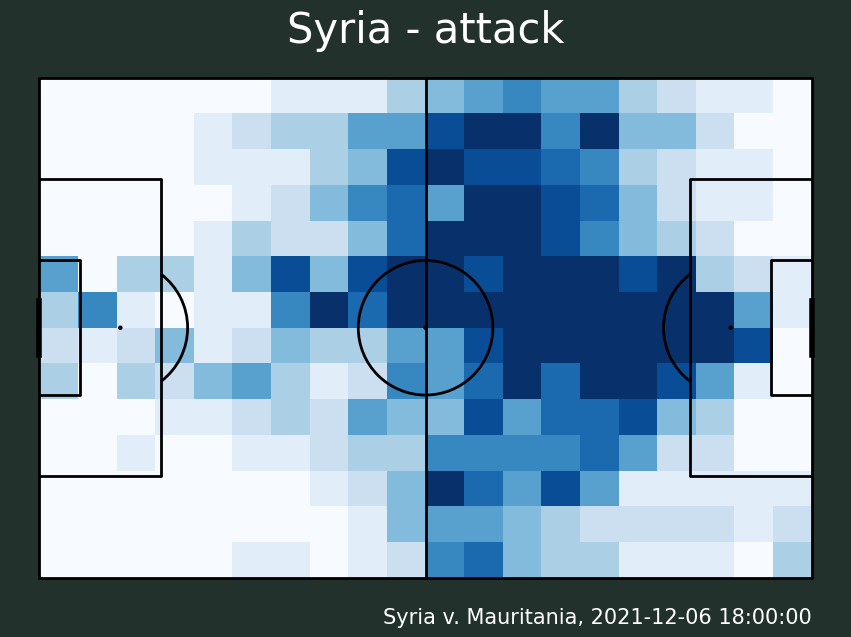

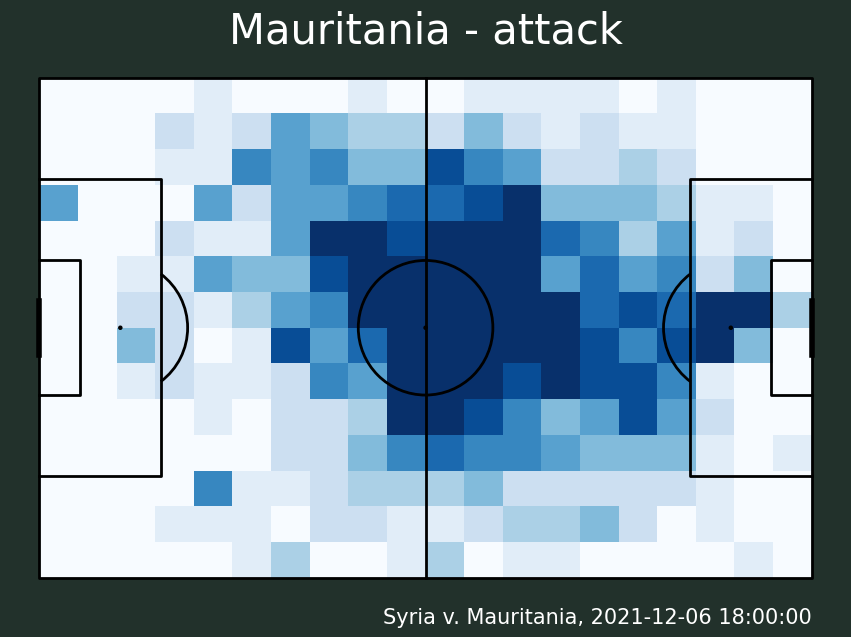

In [16]:
p = source.team_heatmap('Syria', hm_type='attack')
p = source.team_heatmap('Mauritania', hm_type='attack')

## Heatmaps by possession phase
Looking at the heatmaps of the two teams while they are in possession, again we see  that Syria's center of mass is shifted toward the opponent's half, while Mauritania dwells iun its own half. So perhaps Mauritania had trouble getting out of its half, or maybe thay had a deliberate strategy to play long balls into the attack, which typically result in lower time of possession in the attacking third. The possession statistics form the TF05 file are aligned with this line of thinking, too:  Syria had 63% possession and, when in possession, its possession sequences where 39% loger than Mauritania's (9.7 seconds vs. 5.9 seconds). Again, watching the video will help clarify these hypoteses, but isn't it cool that we can get a general idea of how the teams played from jsut a few summary heatmaps? 

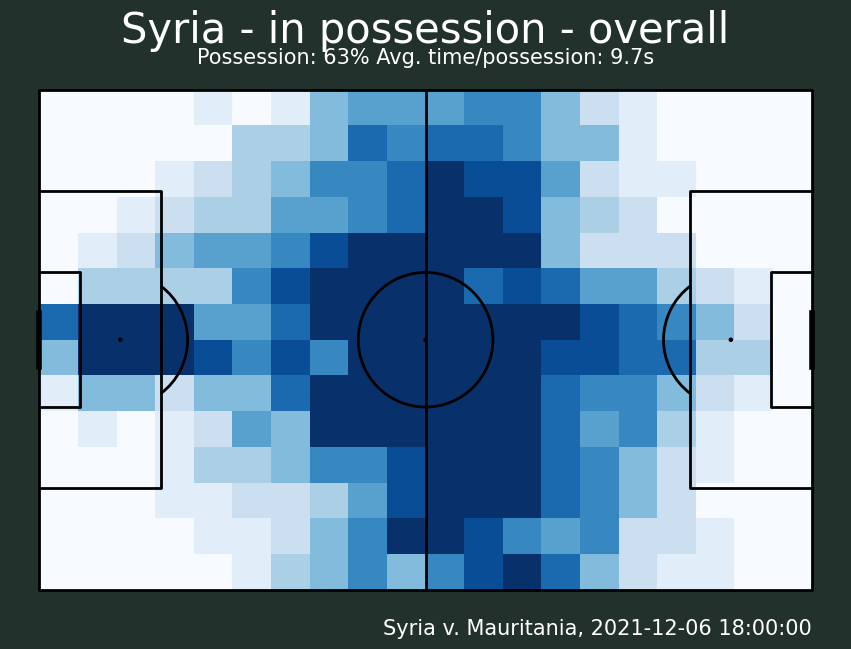

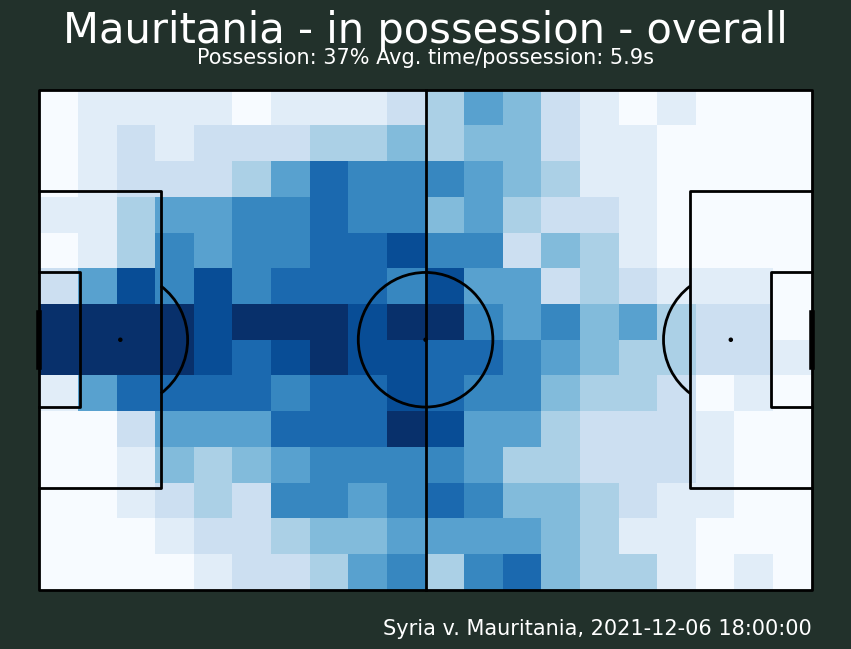

In [17]:
p = source.team_possession_heatmap('Syria', possession='in')
p = source.team_possession_heatmap('Mauritania', possession='in')

Inspecting the heatmaps when the teams are out of possession, we see that Syria's block is a bit higher up the pitch than Mauritania's. consistent with previous observations. Note how Mauritania's heatmap is an almost perfect defensive funnel. Visually, it's as if the defence and midfield heatmaps from the above discussion were combined into one to obtain the out-of-possession heatmap. THis hints again at Mauritania employing their midfield mostly in a defensive stance, supporting the defensive unit. 

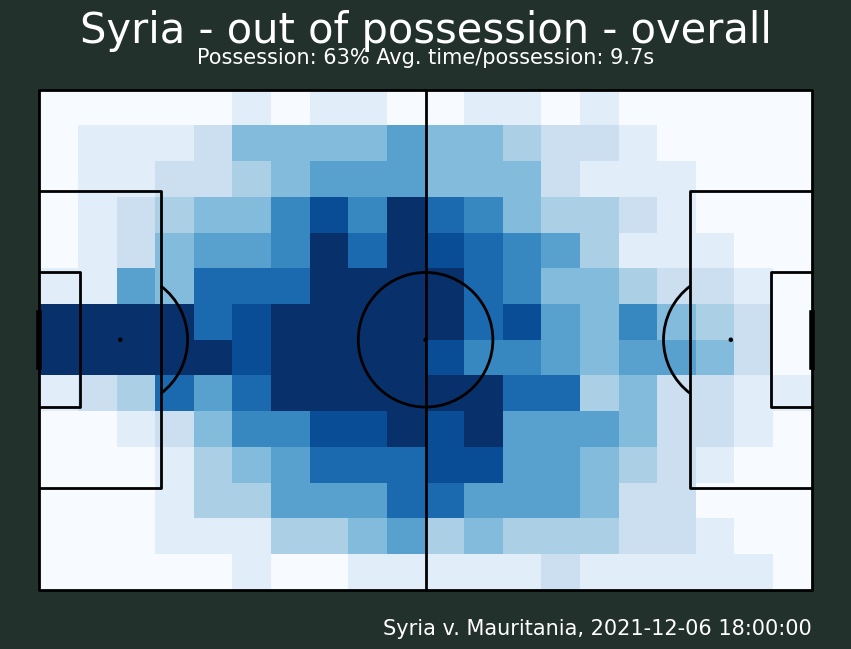

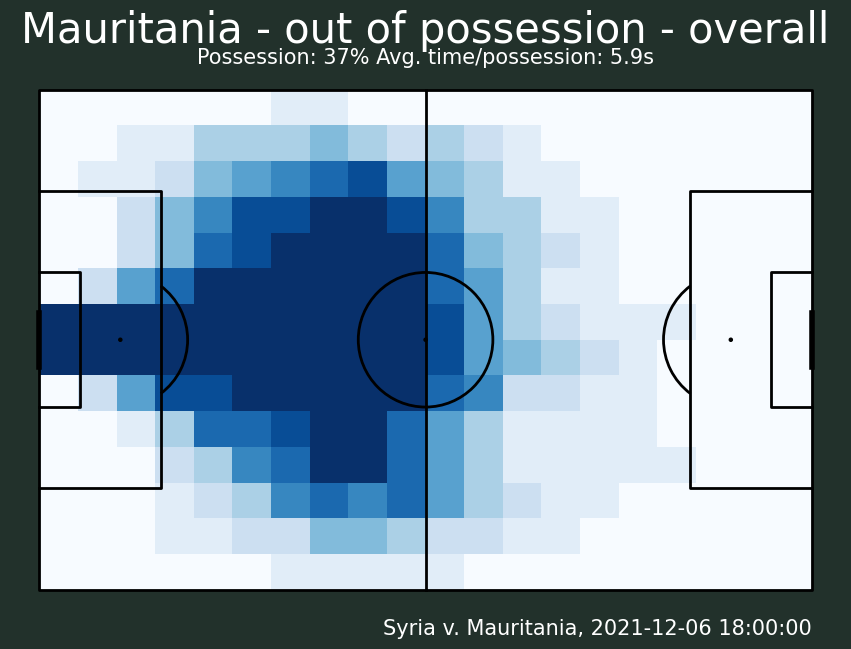

In [18]:
p = source.team_possession_heatmap('Syria', possession='out')
p = source.team_possession_heatmap('Mauritania', possession='out')

# Plotting the heatmaps of individual players

In [ ]:
Appendix A: more plot types

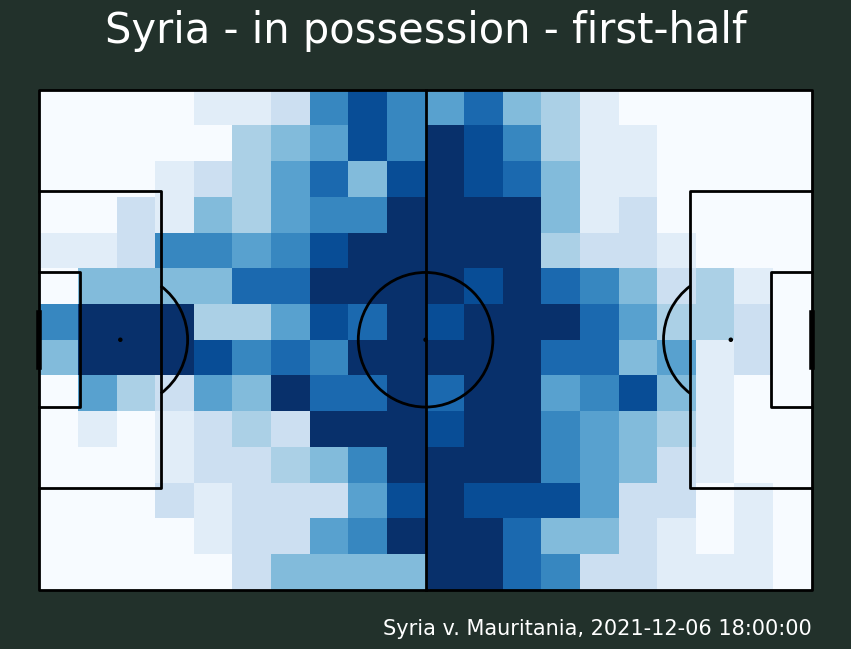

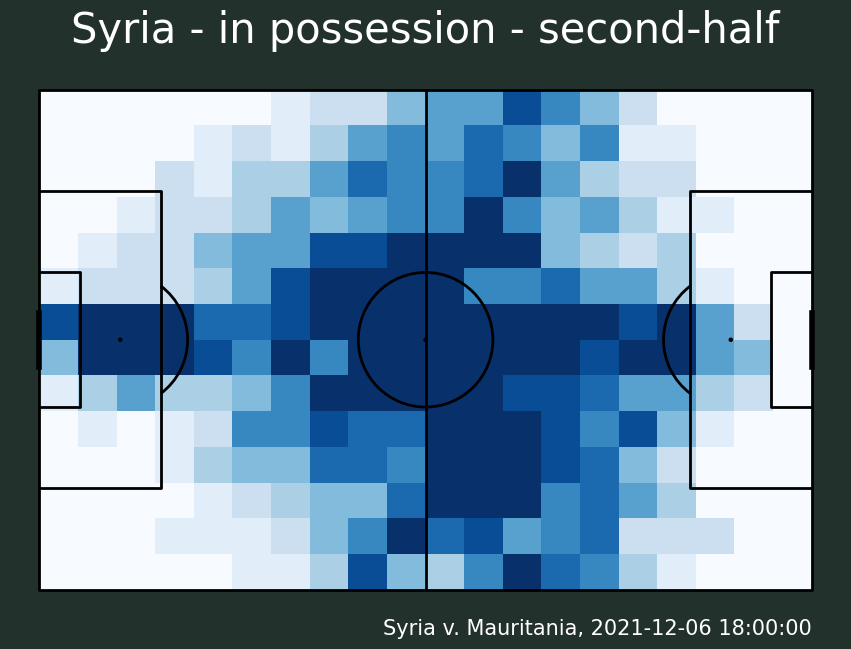

In [19]:
p = source.team_possession_heatmap('Syria', possession='in', hm_type='first-half')
p = source.team_possession_heatmap('Syria', possession='in', hm_type='second-half')

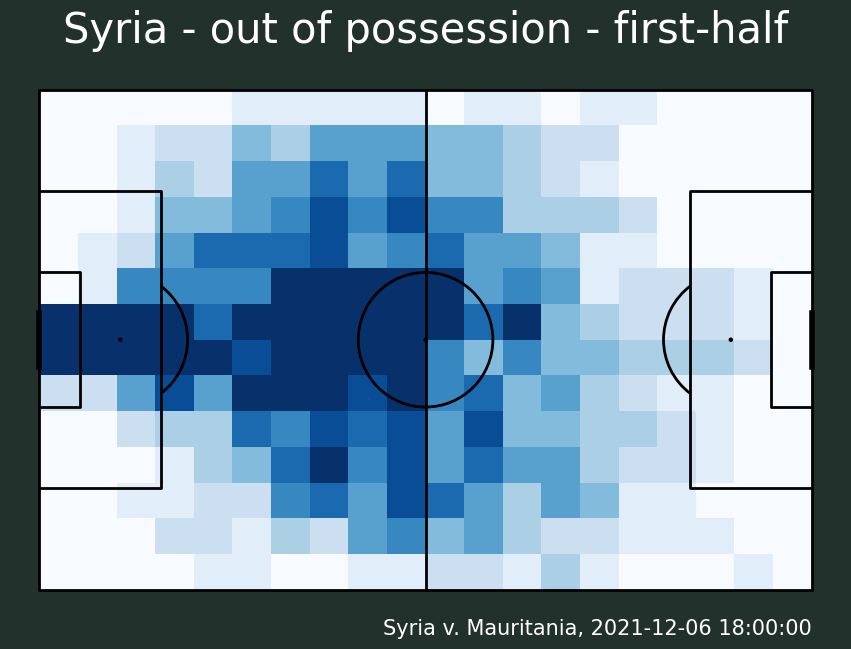

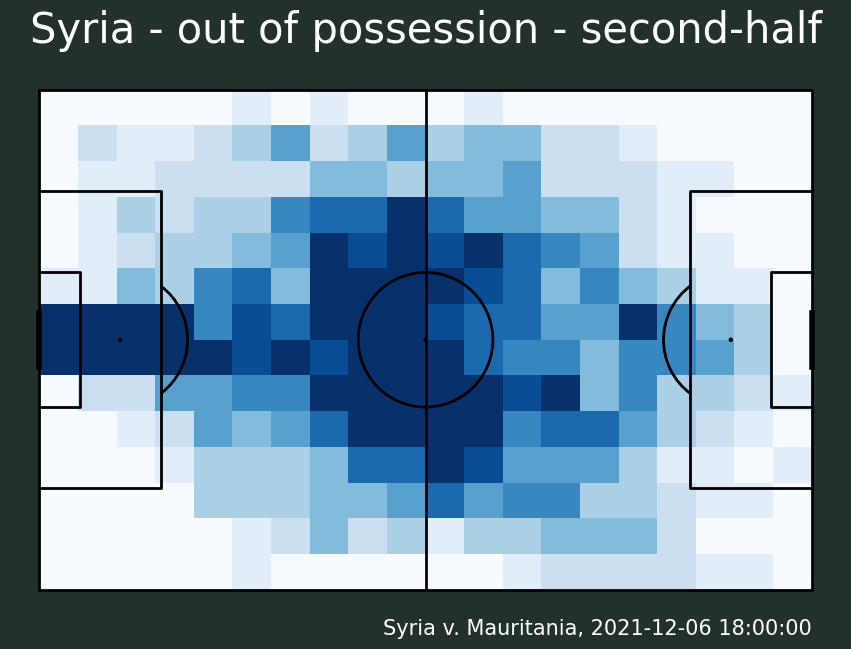

In [20]:
p = source.team_possession_heatmap('Syria', possession='out', hm_type='first-half')
p = source.team_possession_heatmap('Syria', possession='out', hm_type='second-half')

In [ ]:
Appendix B: tfutils technical details